We recently released [PyMC3 3.1](https://github.com/pymc-devs/pymc3/blob/master/RELEASE-NOTES.md#pymc3-31-june-23-2017) after the first stable 3.0 release in January 2017. You can update either via `pip install pymc3` or via `conda install -c conda-forge pymc3`.

A lot is happening in PyMC3-land. One thing I am particularily proud of is the developer community we have built. We now have around 10 active core contributors from the US, Germany, Russia, Japan and Switzerland. Specifically, since 3.0, Adrian Seyboldt, [Junpeng Lao](http://www.unifr.ch/psycho/staff/lao-junpeng) and Hannes Bathke have joined the team. Moreover, we have 3 Google Summer of Code students: [Maxime Kochurov](https://ferrine.github.io), who is working on Variational Inference; Bill Engels, who is working on Gaussian Processes, and Bhargav Srinivasa is implementing Riemannian HMC. 

Moreover, PyMC3 is being seeing increased adoption in [academia](https://scholar.google.de/scholar?hl=en&as_sdt=0,5&sciodt=0,5&cites=6936955228135731011&scipsc=&authuser=1&q=&scisbd=1), as well as in [industry](https://github.com/pymc-devs/pymc3/wiki/Testimonials).

Here, I want to highlight some of the new features of PyMC3 3.1.

## Discourse forum + better docs

To facilitate the community building process and give users a place to ask questions we have a launched a discourse forum: [http://discourse.pymc.io](http://discourse.pymc.io). Bug reports should still onto the [Github issue tracker](https://github.com/pymc-devs/pymc3/issues), but for all PyMC3 questions or modeling discussions, please use the discourse forum.

There are also some improvements to the documentation. Mainly, a [quick-start to the general PyMC3 API](http://pymc-devs.github.io/pymc3/notebooks/api_quickstart.html), and a [quick-start to the variational API](http://pymc-devs.github.io/pymc3/notebooks/variational_api_quickstart.html).

## Gaussian Processes

PyMC3 now as high-level support for GPs which allow for very flexible non-linear curve-fitting (among other things). This work was mainly done by Bill Engels with help from Chris Fonnesbeck. Here, we highlight the basic API, but for more information see the [full introduction](http://pymc-devs.github.io/pymc3/notebooks/GP-introduction.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

import numpy as np
import scipy as sp
import seaborn as sns

import theano
import theano.tensor as tt
import theano.tensor.nlinalg

import pymc3 as pm

In [3]:
np.random.seed(20090425)
n = 20
X = pm.floatX(np.sort(3*np.random.rand(n))[:,None])

# generate fake data from GP with white noise (with variance sigma2)
y = pm.floatX(
    np.array([ 1.36653628,  1.15196999,  0.82142869,  0.85243384,  0.63436304,
               0.14416139,  0.09454237,  0.32878065,  0.51946622,  0.58603513,
               0.46938673,  0.63876778,  0.48415033,  1.28011185,  1.52401102,
               1.38430047,  0.47455605, -0.21110139, -0.49443319, -0.25518805])
)

In [4]:
Z = pm.floatX(np.linspace(0, 3, 100)[:, None])

with pm.Model() as model:
    # priors on the covariance function hyperparameters and noise
    l = pm.Uniform('l', 0, 10)
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    f_cov = tt.exp(log_s2_f) * pm.gp.cov.ExpQuad(1, l)

    # Instantiate GP
    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=tt.exp(log_s2_n), 
                     observed={'X': X, 'Y': y})
    
    trace = pm.sample()
    
    # Draw samples from GP
    gp_samples = pm.gp.sample_gp(trace, y_obs, Z, samples=50, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 27.649:   6%|▌         | 12091/200000 [00:09<02:15, 1386.23it/s]
Convergence archived at 12100
Interrupted at 12,100 [6%]: Average Loss = 9,348
100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


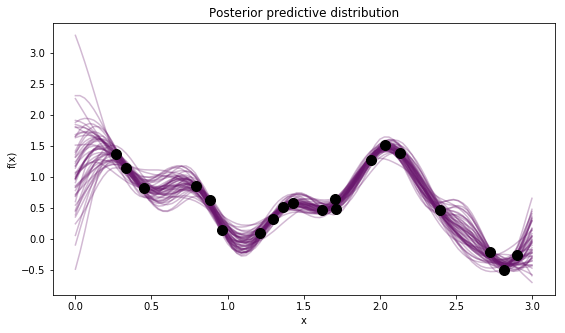

In [5]:
fig, ax = plt.subplots(figsize=(9, 5))

[ax.plot(Z, x, color=cm(0.3), alpha=0.3) for x in gp_samples]
# overlay the observed data
ax.plot(X, y, 'ok', ms=10);
ax.set(xlabel="x", ylabel="f(x)", title="Posterior predictive distribution");

## Improvements to NUTS

NUTS is now identical to Stan's implementation and also much much faster. In addition, Adrian Seyboldt added [higher-order integrators](http://pymc-devs.github.io/pymc3/api/inference.html#module-pymc3.step_methods.hmc.nuts), which promise to be more efficient in higher dimensions, and [sampler statistics](http://pymc-devs.github.io/pymc3/notebooks/sampler-stats.html) that help identify problems with NUTS sampling.

In addition, we changed the default kwargs of `pm.sample()`. By default, the sampler is run for 500 iterations with tuning enabled (you can change this with the `tune` kwarg), these samples are then discarded from the returned trace. Moreover, if no arguments are specified, `sample()` will draw 500 samples in addition to the tuning samples. So for almost all models, just calling `pm.sample()` should be sufficient.

In [12]:
with pm.Model():
    mu1 = pm.Normal("mu1", mu=0, sd=1, shape=1000)
    trace = pm.sample(discard_tuned_samples=False) # do not remove tuned samples for the plot below

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 7.279:  14%|█▍        | 28648/200000 [00:08<00:53, 3176.47it/s] 
Convergence archived at 28900
Interrupted at 28,900 [14%]: Average Loss = 8.9536
100%|██████████| 1000/1000 [00:03<00:00, 263.60it/s]


`trace` now has a bunch of extra parameters pertaining to statistics of the sampler:

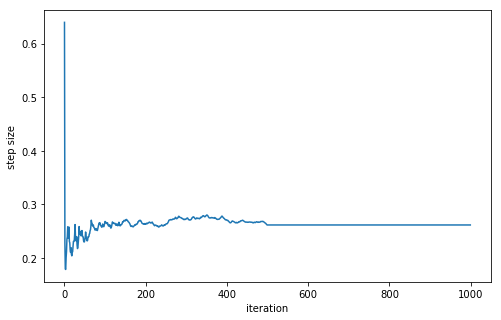

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(trace['step_size_bar']); ax.set(xlabel='iteration', ylabel='step size');

## Variational Inference

[Maxim "Ferrine" Kochurov](https://ferrine.github.io) has done outstanding contributions to improve support for Variational Inference. Essentially, Ferrine has implemented [Operator Variational Inference (OPVI)](https://arxiv.org/abs/1610.09033) which is a framework to express many existing VI approaches in a modular fashion. He has also made it much easier to supply mini-batches. See [here](http://pymc-devs.github.io/pymc3/notebooks/variational_api_quickstart.html) for a full overview of the capabilities.

Specifically, PyMC3 supports the following VI methods:
* Auto-diff Variational Inference (ADVI) mean-field
* ADVI full rank
* Stein Variational Gradient Descent (SVGD)
* Armortized SVGD

In addition, Ferrine is making great progress on adding Flows which allows learning very flexible transformations of the VI approximation to learn more complex (i.e. non-normal) posterior distributions.

In [31]:
x = np.random.randn(10000)
x_mini = pm.Minibatch(x, batch_size=100)

with pm.Model():
    mu = pm.Normal('x', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=x_mini)
    vi_est = pm.fit() # Run ADVI
    vi_trace = vi_est.sample() # sample from VI posterior

Average Loss = 149.38: 100%|██████████| 10000/10000 [00:01<00:00, 9014.13it/s]
Finished [100%]: Average Loss = 149.33


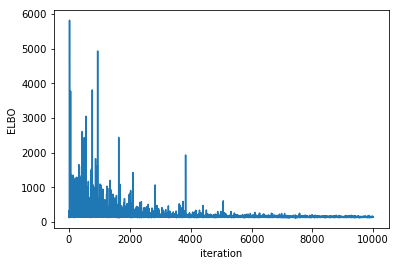

In [26]:
plt.plot(vi_est.hist)
plt.ylabel('ELBO'); plt.xlabel('iteration');

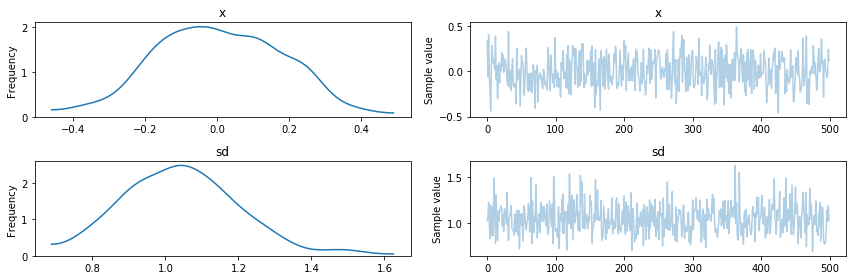

In [34]:
pm.traceplot(vi_trace);

As you can see, we have also added a new high-level API in the spirit of `sample`: `pymc3.fit()` with many configuration options:

In [36]:
help(pm.fit)

Help on function fit in module pymc3.variational.inference:

fit(n=10000, local_rv=None, method='advi', model=None, random_seed=None, start=None, inf_kwargs=None, **kwargs)
    Handy shortcut for using inference methods in functional way
    
    Parameters
    ----------
    n : `int`
        number of iterations
    local_rv : dict[var->tuple]
        mapping {model_variable -> local_variable (:math:`\mu`, :math:`\rho`)}
        Local Vars are used for Autoencoding Variational Bayes
        See (AEVB; Kingma and Welling, 2014) for details
    method : str or :class:`Inference`
        string name is case insensitive in {'advi', 'fullrank_advi', 'advi->fullrank_advi', 'svgd', 'asvgd'}
    model : :class:`pymc3.Model`
        PyMC3 model for inference
    random_seed : None or int
        leave None to use package global RandomStream or other
        valid value to create instance specific one
    inf_kwargs : dict
        additional kwargs passed to :class:`Inference`
    start : `Poi

SVGD for example is an algorithm that updates multiple particles and is thus well suited for multi-modal posteriors. 

In [49]:
with pm.Model():
    pm.NormalMixture('m', 
                     mu=np.array([0., .5]), 
                     w=np.array([.4, .6]), 
                     sd=np.array([.1, .1]))
    vi_est = pm.fit(method='SVGD')
    vi_est = vi_est.sample(5000)

100%|██████████| 10000/10000 [00:24<00:00, 407.10it/s]


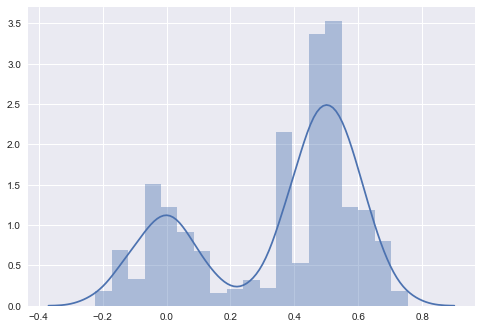

In [50]:
sns.distplot(vi_est['m'])

## Cholesky factorization

There is a nice trick to covariance estimation using the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) for increased efficiency and numerical stability. The `MvNormal` distribution now accepts a Cholesky-factored covariance matrix. In addition, the LKJ prior has been changed to provide the Cholesky covariance matrix. Thus, if you are estimating covariances, definitely use this much improved parameterization.

In [20]:
n_dim = 5
data = np.random.randn(100, n_dim)

with pm.Model() as model:
    # Note that we access the distribution for the standard
    # deviations, and do not create a new random variable.
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=n_dim, 
                                    sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(n_dim, packed_chol, lower=True)

    # Define a new MvNormal with the given covariance
    vals = pm.MvNormal('vals', mu=np.zeros(n_dim), 
                       chol=chol, shape=n_dim,
                       observed=data)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 716.37:   8%|▊         | 15309/200000 [00:05<01:06, 2768.80it/s]
Convergence archived at 15400
Interrupted at 15,400 [7%]: Average Loss = 2,171.4
100%|██████████| 1000/1000 [00:06<00:00, 160.64it/s]


## Live-trace to see sampling in real-time

This one is really cool, you can watch the trace evolve while its sampling using `pm.sample(live_plot=True)`. Contributed by David Brochart. See [here](http://pymc-devs.github.io/pymc3/notebooks/live_sample_plots.html) for full docs.

## Better display of random variables

We now make use of the fancy display features of the Jupyter Notebook to provide a nicer view of RVs:

In [12]:
with pm.Model():
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    γ = pm.Normal('γ', mu=μ, sd=σ, observed=np.random.randn(100))

In [13]:
γ

γ

You can create greek letters in the Jupyter Notebook by typing the $\LaTeX$ command and hitting tab: \mu[tab].

## GPU support (experimental)

While still experimental, we have made a lot of progress towards fully supporting `float32` throughout. If you set `floatX = float32` in your `.theanorc`, cast all your input data to `float32` (e.g. by using `pm.floatX()` for automatic casting), you should get much faster inference. If you set the backend to use the GPU, you should get a nice speed-up on the right types of models. Please report any successes or failures in this regard.

## Other useful packages

These are not part of PyMC3 3.1 but build on it and should be of interest to many users.

### Bayesian Deep Learning with Gelato

Gelato bridges PyMC3 and Lasagne, a library to easily build Neural Networks similar to Keras. Building Bayesian convolution neural networks and estimating them using VI has never been simpler. See [here](https://github.com/ferrine/gelato/blob/master/examples/mnist.ipynb) for an example on MNIST.  

### Building hierarchical GLMs with Bambi

[Bambi](https://github.com/bambinos/bambi) is a new package on top of PyMC3 (they also recently added a Stan backend) which allows creation of complex, hierarchical GLMs with very intuitive syntax, e.g.:

`model.fit('rt ~ condition', random=['condition|subject', '1|stimulus'], samples=5000, chains=2)`.

## Looking towards PyMC3 3.2

PyMC3 3.2 is already underway. Some of the features we are working on include: 
* [faster sampling on the GPU](https://github.com/pymc-devs/pymc3/pull/2345),
* [Stochastic Gradient Fisher Scoring for scalable min-batch MCMC](https://github.com/pymc-devs/pymc3/pull/1977),
* [Normalizing Flows](https://github.com/pymc-devs/pymc3/pull/2362) for flexible variational inference on non-normal posteriors, 
* [scalable GPs](https://github.com/pymc-devs/pymc3/pull/2322), 
* [support for the `emcee` sampler](External emcee sampler support ), and 
* [Riemannian HMC](https://github.com/pymc-devs/pymc3/pull/2240) for efficient sampling in high-dimensional complex spaces. 

## On my own behalf: Patreon

I have recently created an account on Patreon where you can [support me financially](https://www.patreon.com/twiecki) for writing blog posts. These allow me to devote more time to writing posts so if you find this blog useful, please consider supporting me.

Thanks specifically to [Jonathan Ng](https://twitter.com/_jonathanng_) for pledging.